In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/playground-series-s3e19/sample_submission.csv
/kaggle/input/playground-series-s3e19/train.csv
/kaggle/input/playground-series-s3e19/test.csv


In [55]:
from category_encoders import OneHotEncoder, MEstimateEncoder, GLMMEncoder, OrdinalEncoder, CatBoostEncoder
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, KFold, TimeSeriesSplit
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor, StackingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, HuberRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, roc_auc_score, roc_curve
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.compose import ColumnTransformer 
from sklearn.calibration import CalibratedClassifierCV
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [11]:
sns.set_theme(style='white', palette='colorblind')
pal = sns.color_palette('colorblind')

In [12]:
train = pd.read_csv("/kaggle/input/playground-series-s3e19/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e19/test.csv")

train.head()


train.drop('id', axis =1, inplace = True)
test.drop('id', axis=1, inplace = True)

In [13]:
test.head()

date    country         store  \
0  2022-01-01  Argentina  Kaggle Learn   
1  2022-01-01  Argentina  Kaggle Learn   
2  2022-01-01  Argentina  Kaggle Learn   
3  2022-01-01  Argentina  Kaggle Learn   
4  2022-01-01  Argentina  Kaggle Learn   

                                          product  
0               Using LLMs to Improve Your Coding  
1                   Using LLMs to Train More LLMs  
2  Using LLMs to Win Friends and Influence People  
3      Using LLMs to Win More Kaggle Competitions  
4                      Using LLMs to Write Better

In [14]:
list(train)

['date', 'country', 'store', 'product', 'num_sold']

In [15]:
train.describe()

num_sold
count  136950.000000
mean      165.522636
std       183.691575
min         2.000000
25%        46.000000
50%        98.000000
75%       184.000000
max      1380.000000

In [16]:
cat_features = ['country','store','product']
num_features = test.drop(cat_features, axis = 1).columns

In [20]:
train.date = pd.to_datetime(train.date, format = "%Y-%m-%d")
test.date = pd.to_datetime(test.date, format = "%Y-%m-%d" )

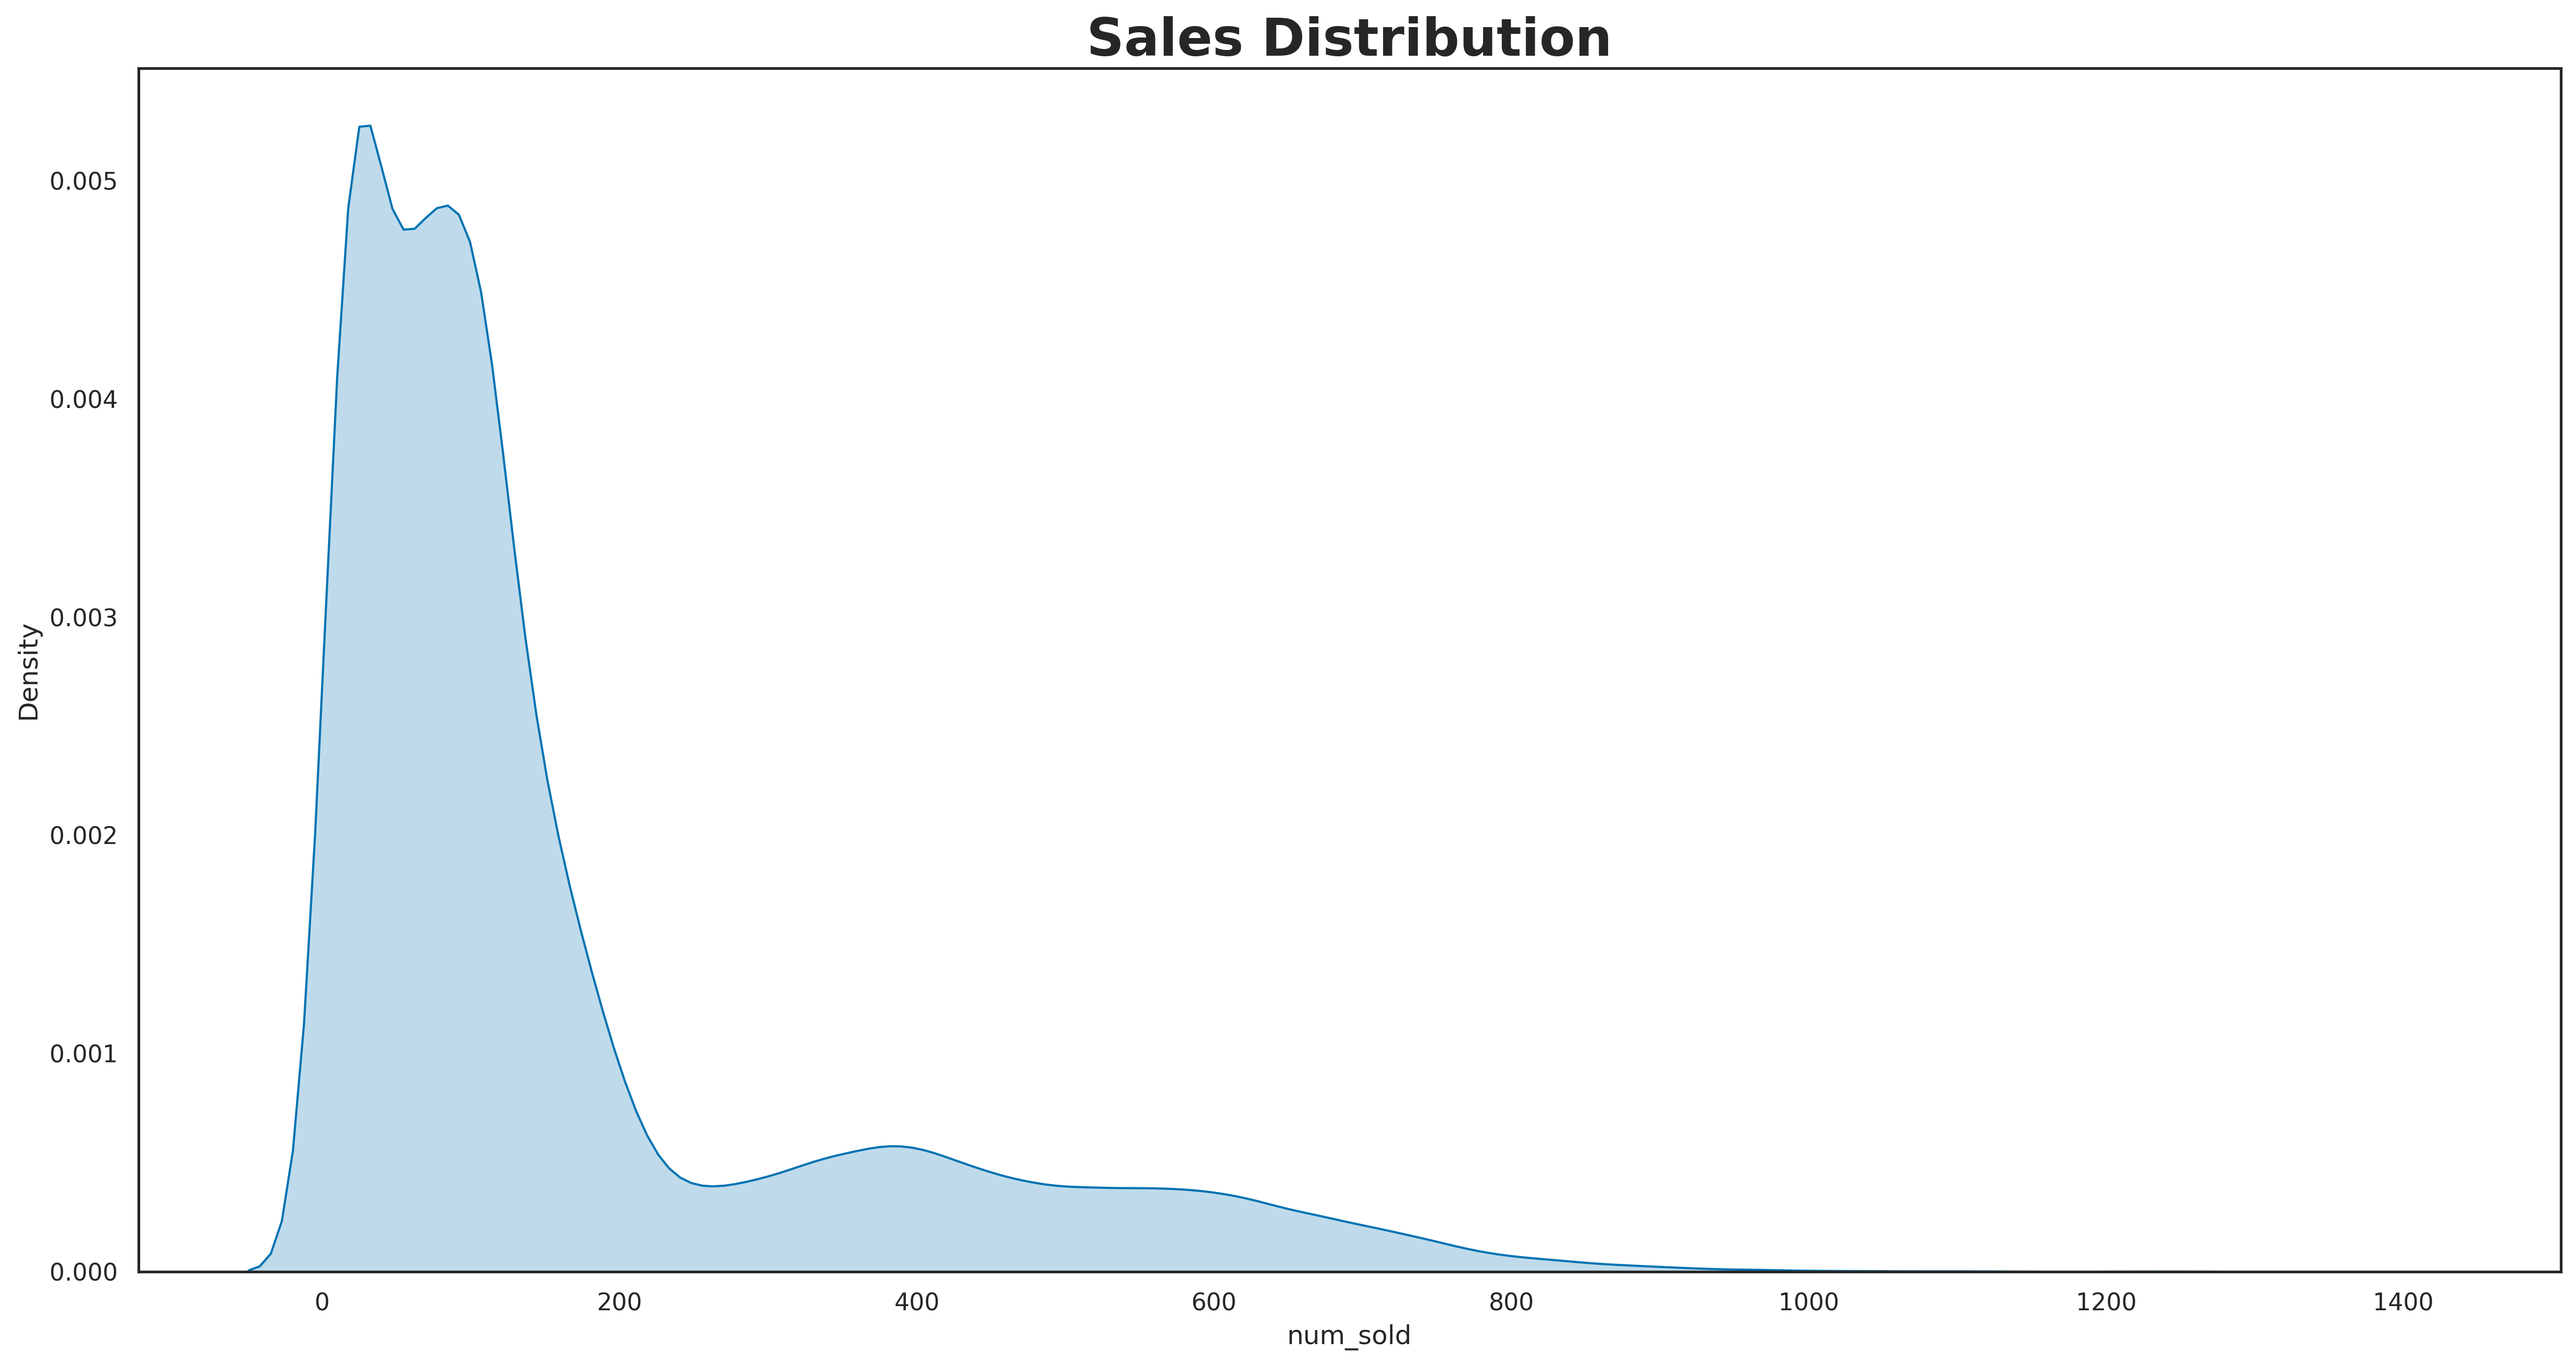

In [22]:
plt.figure(figsize= (20,10), dpi = 300)

sns.kdeplot(data = train, x='num_sold', fill = True)

plt.title("Sales Distribution", fontsize = 24, fontweight = 'bold')
plt.show()

### Sales Growth over time 


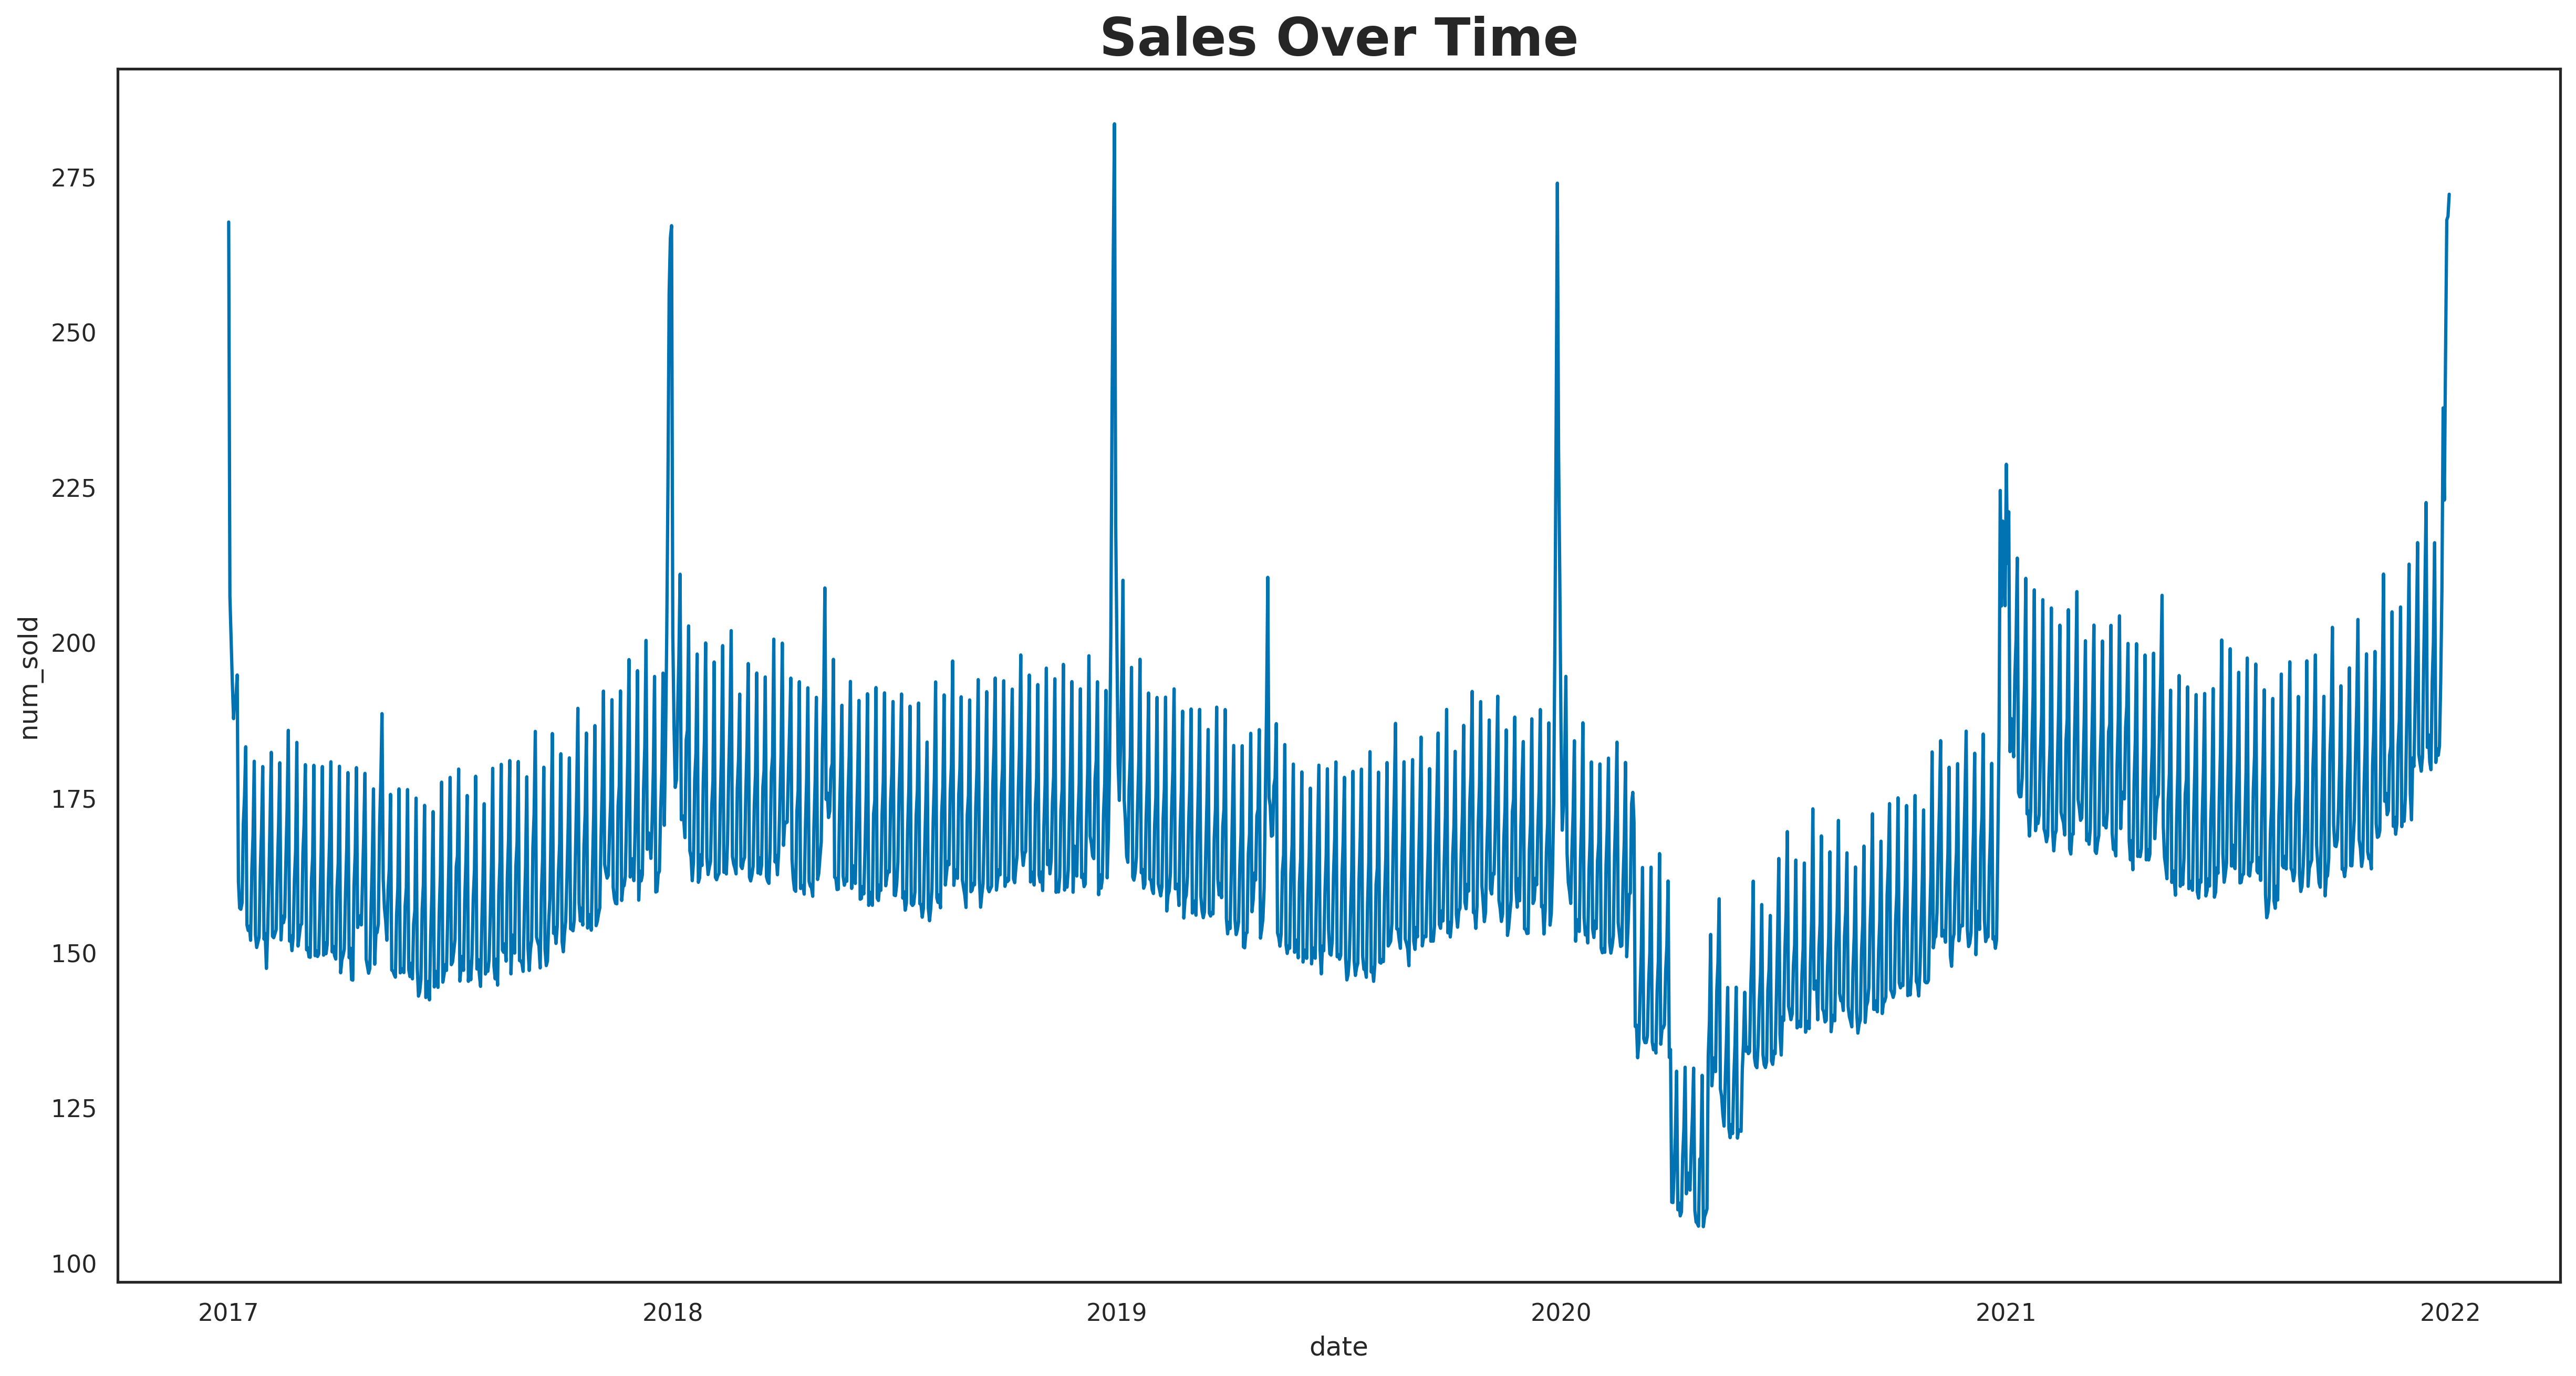

In [24]:
plt.figure(figsize = (20,10), dpi = 300)

sns.lineplot(data = train, x = 'date', y = 'num_sold', errorbar = None)

plt.title("Sales Over Time", fontsize = 24, fontweight = 'bold')
plt.show()

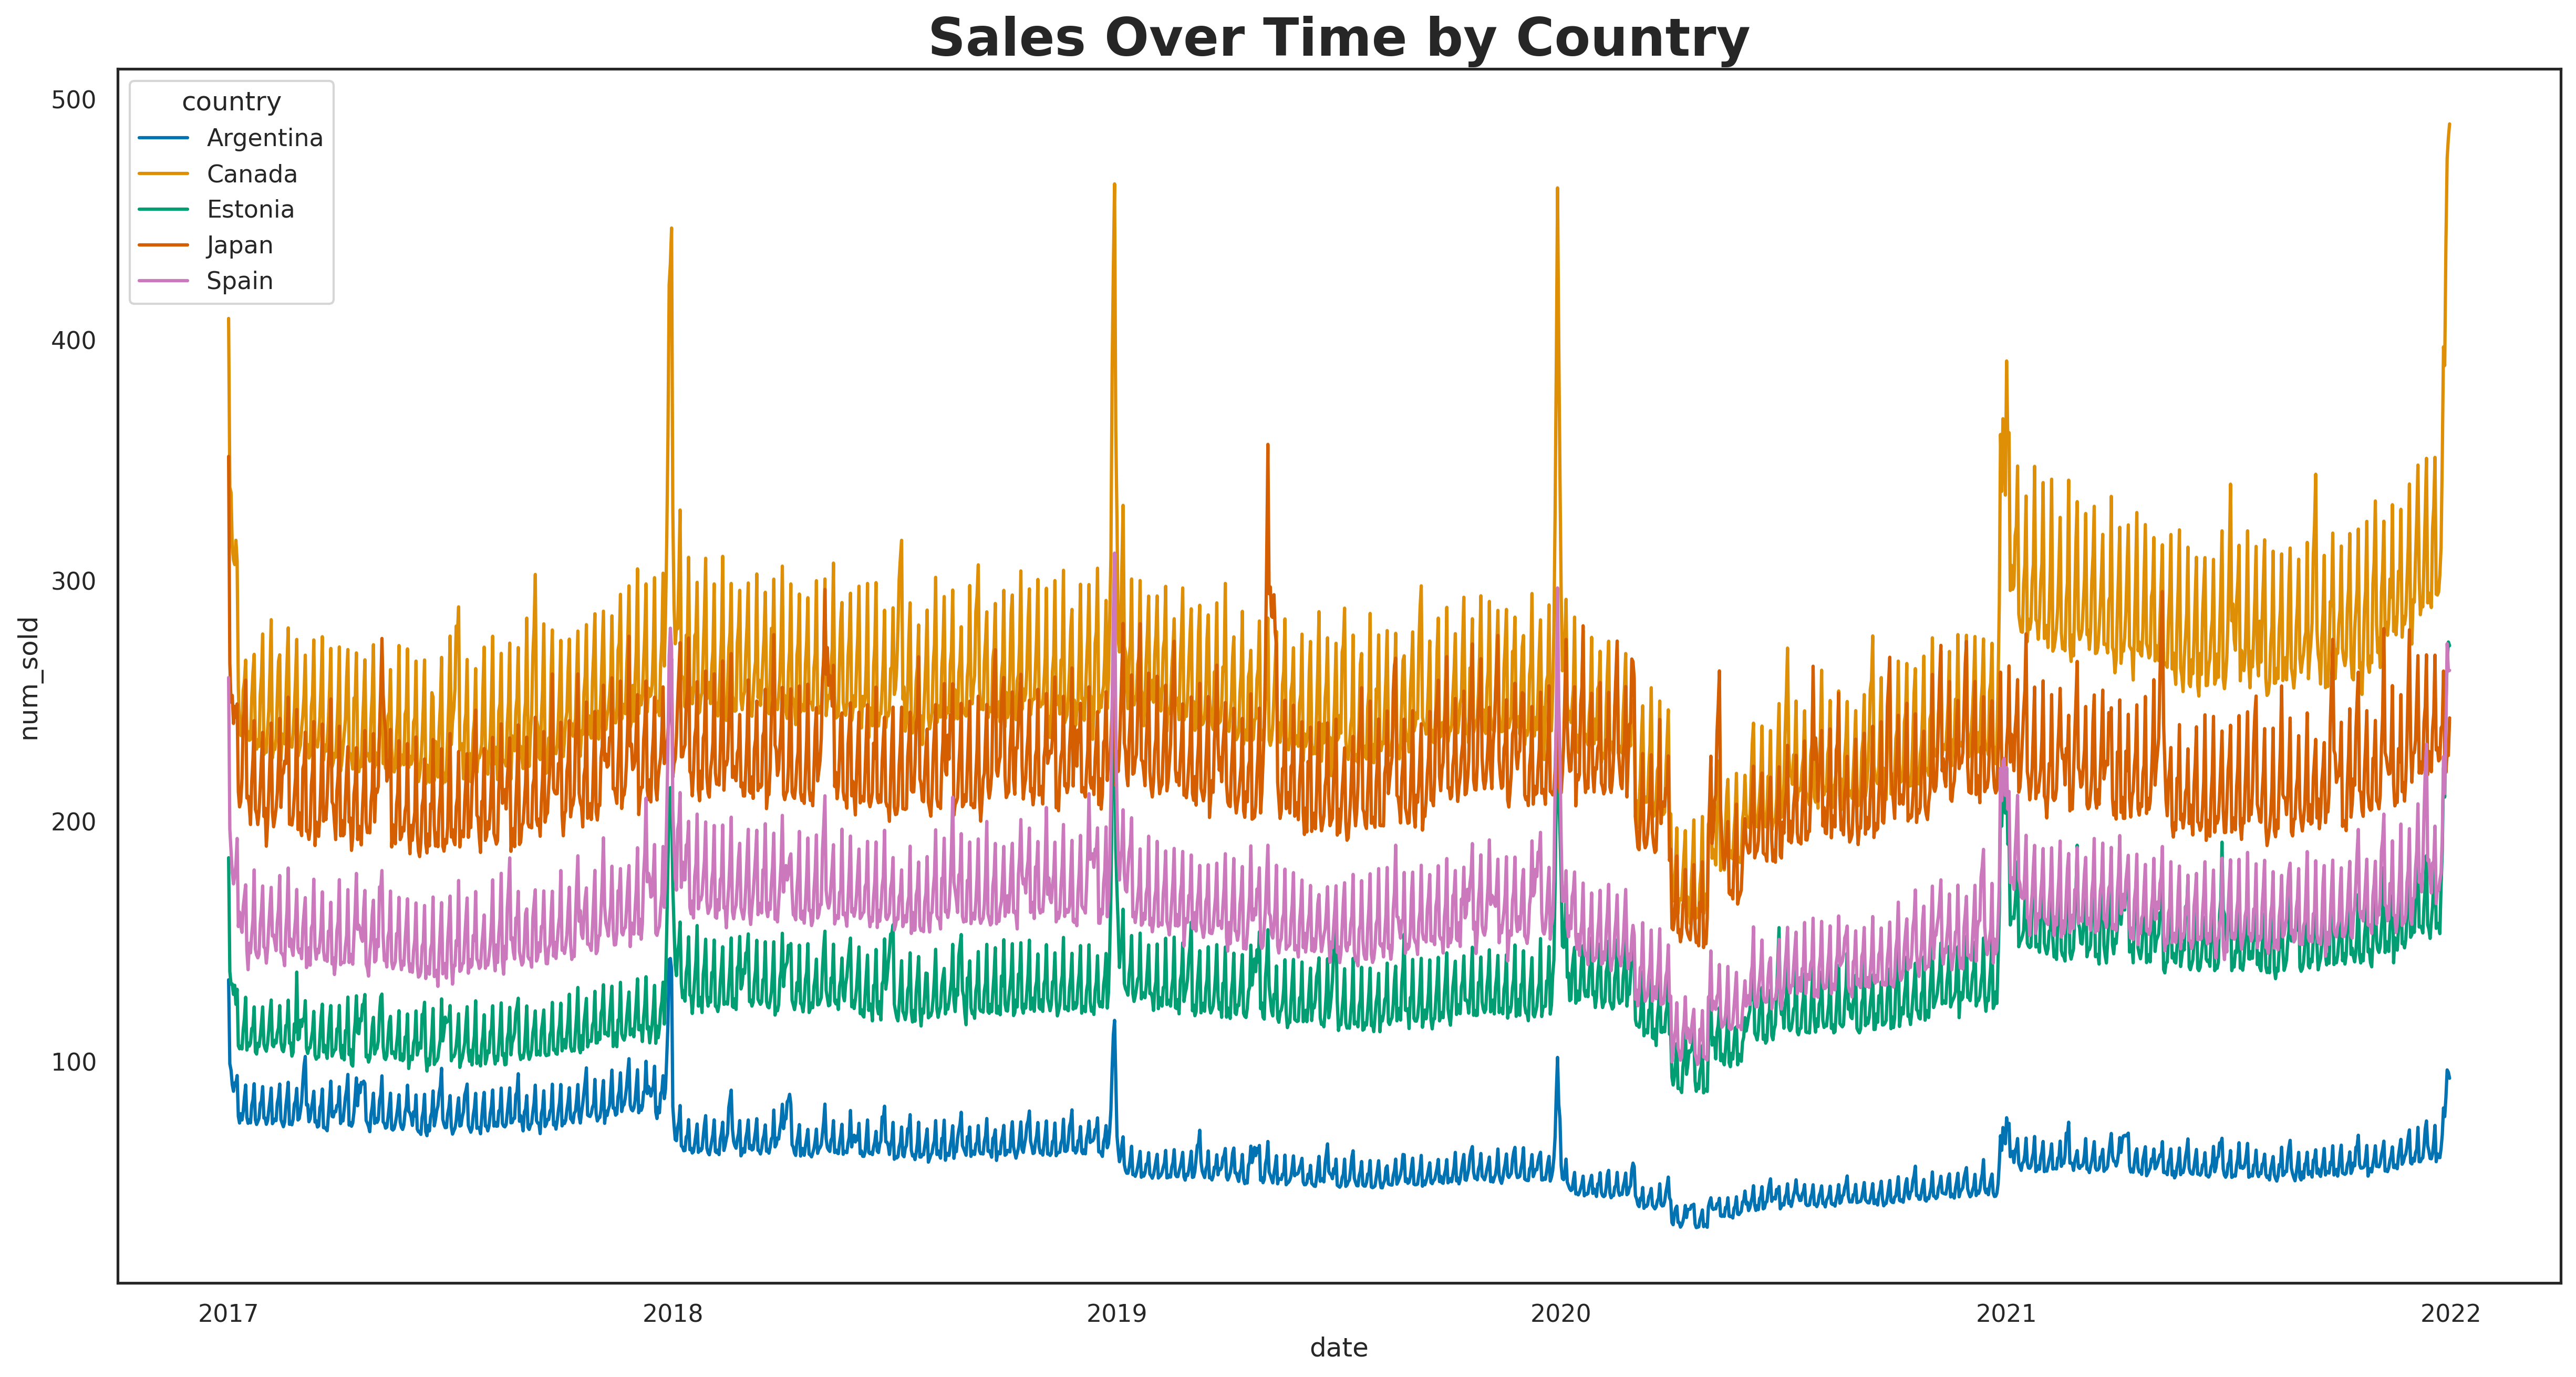

In [25]:
plt.figure(figsize = (20,10), dpi= 300)

sns.lineplot(data = train, x='date', y= 'num_sold', hue = 'country', errorbar = None)

plt.title('Sales Over Time by Country', fontsize = 24, fontweight = 'bold')
plt.show()

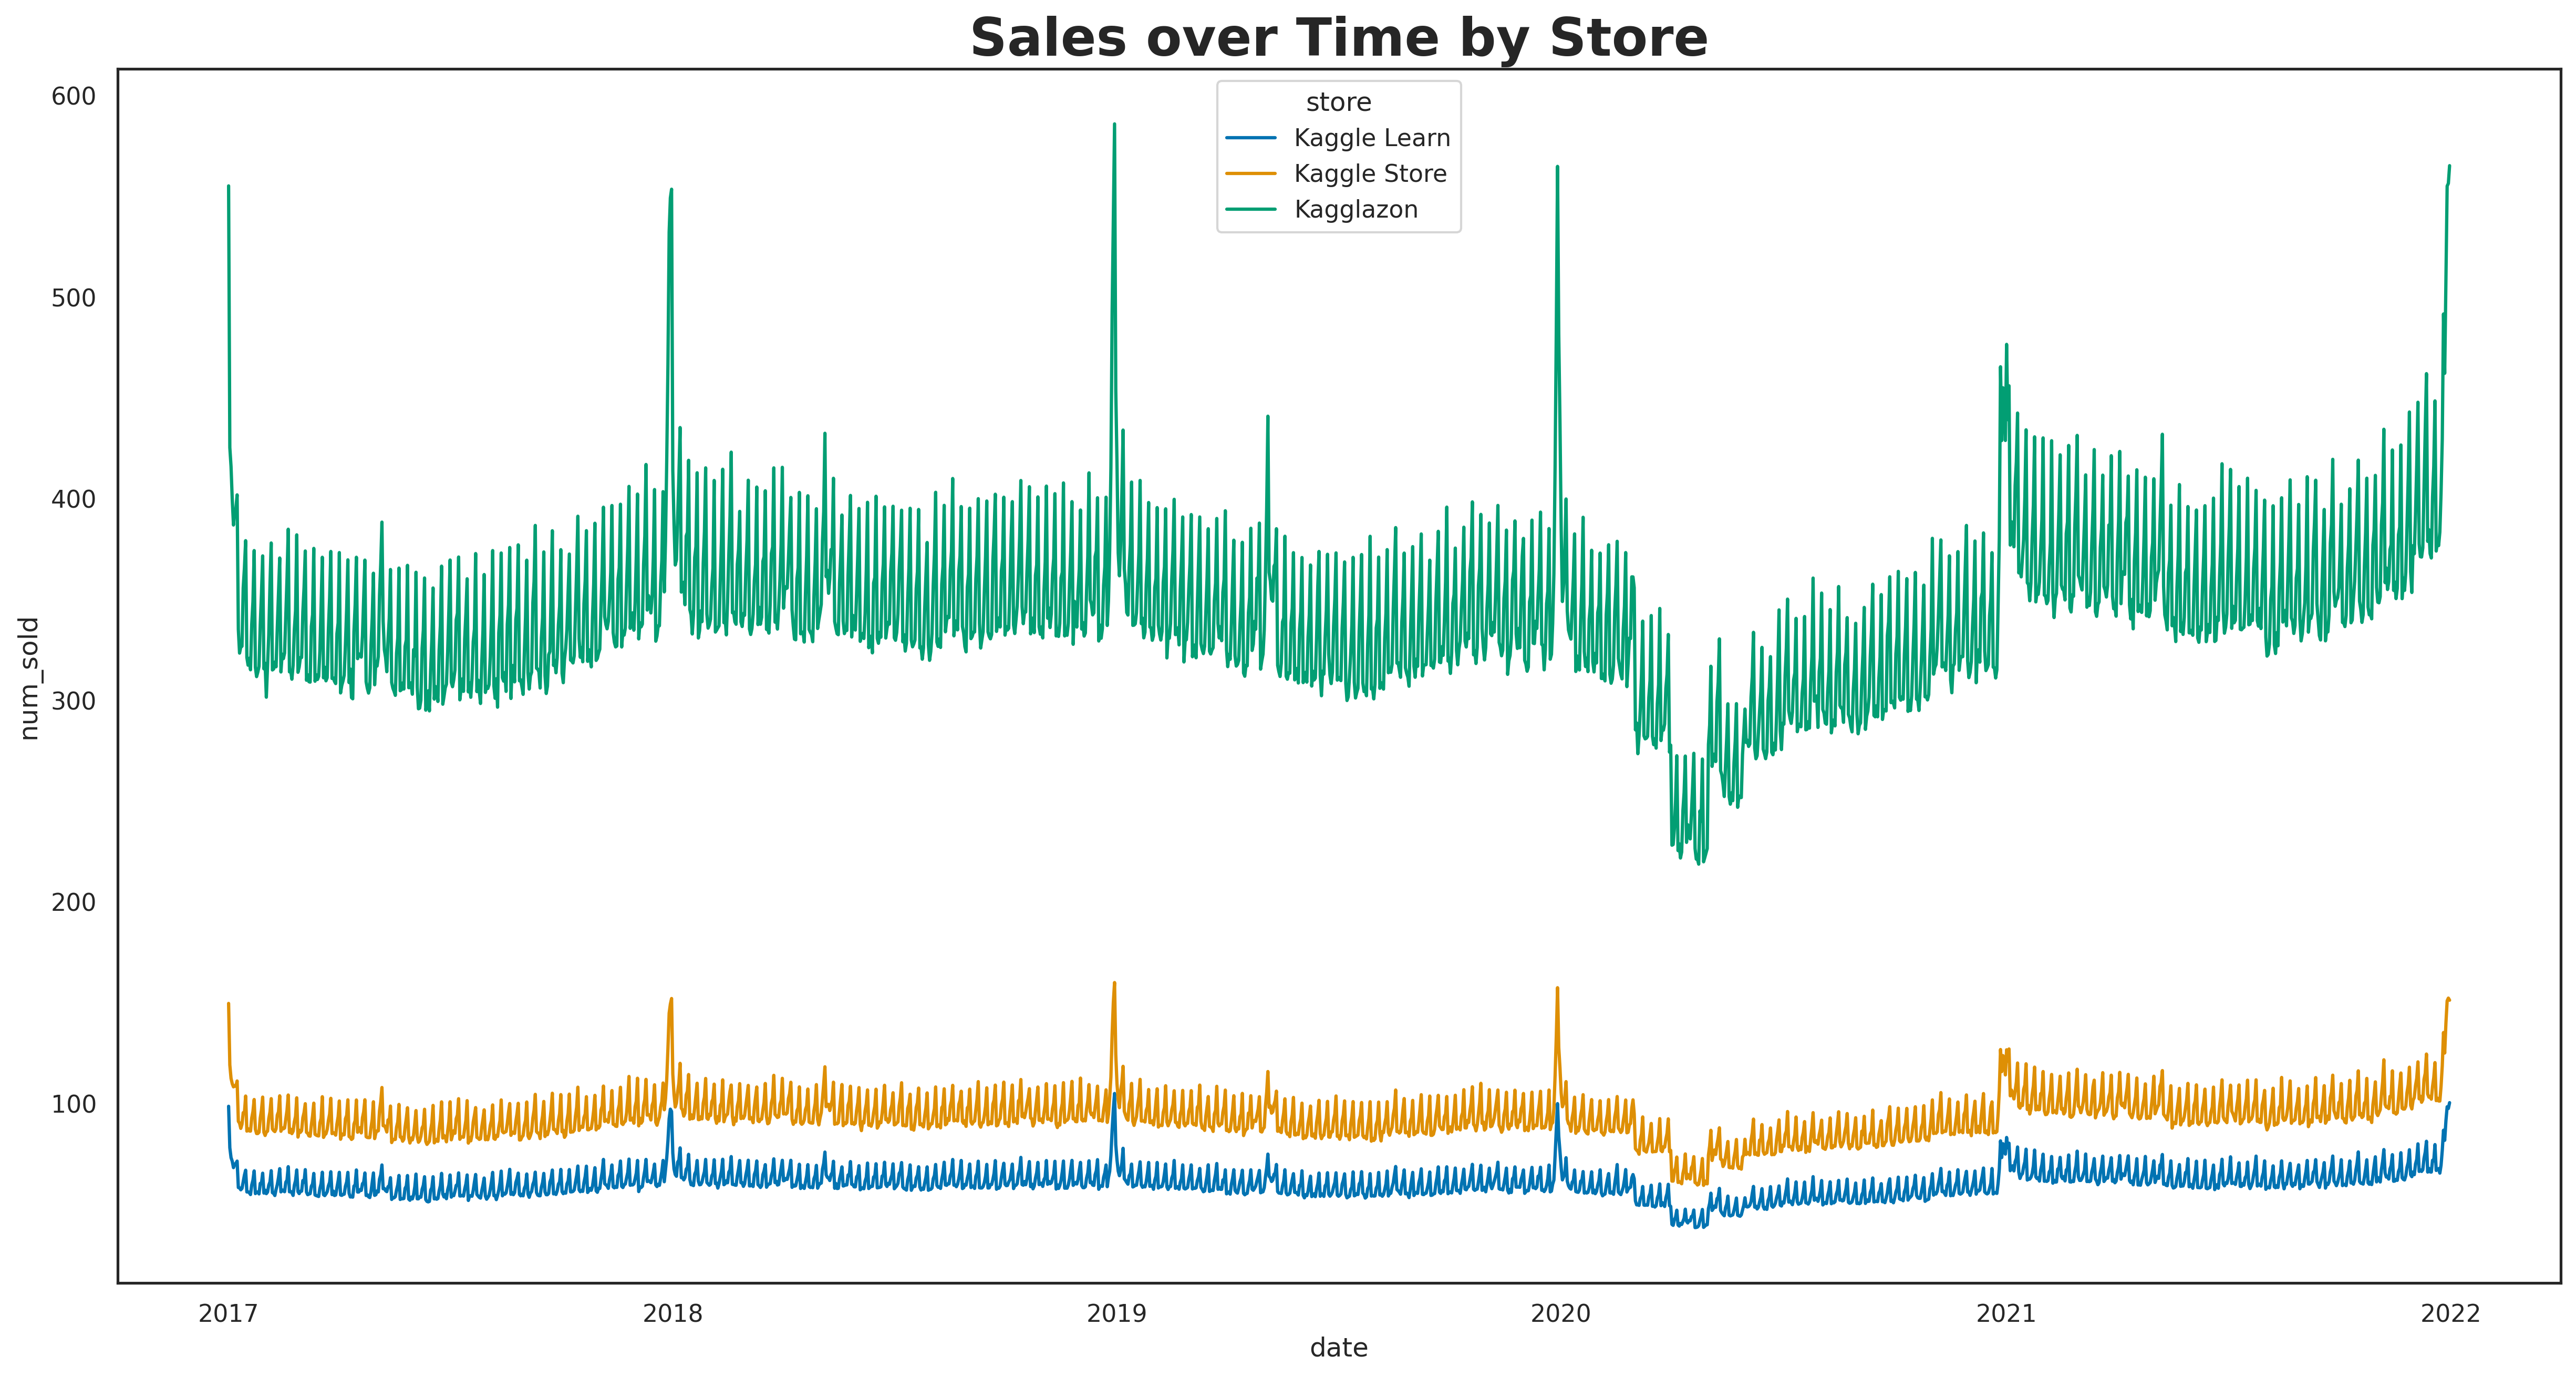

In [27]:
plt.figure(figsize = (20,10), dpi = 300)
sns.lineplot(data = train, x= 'date', y = 'num_sold', hue = 'store', errorbar = None)

plt.title("Sales over Time by Store", fontsize = 24, fontweight = 'bold')
plt.show()

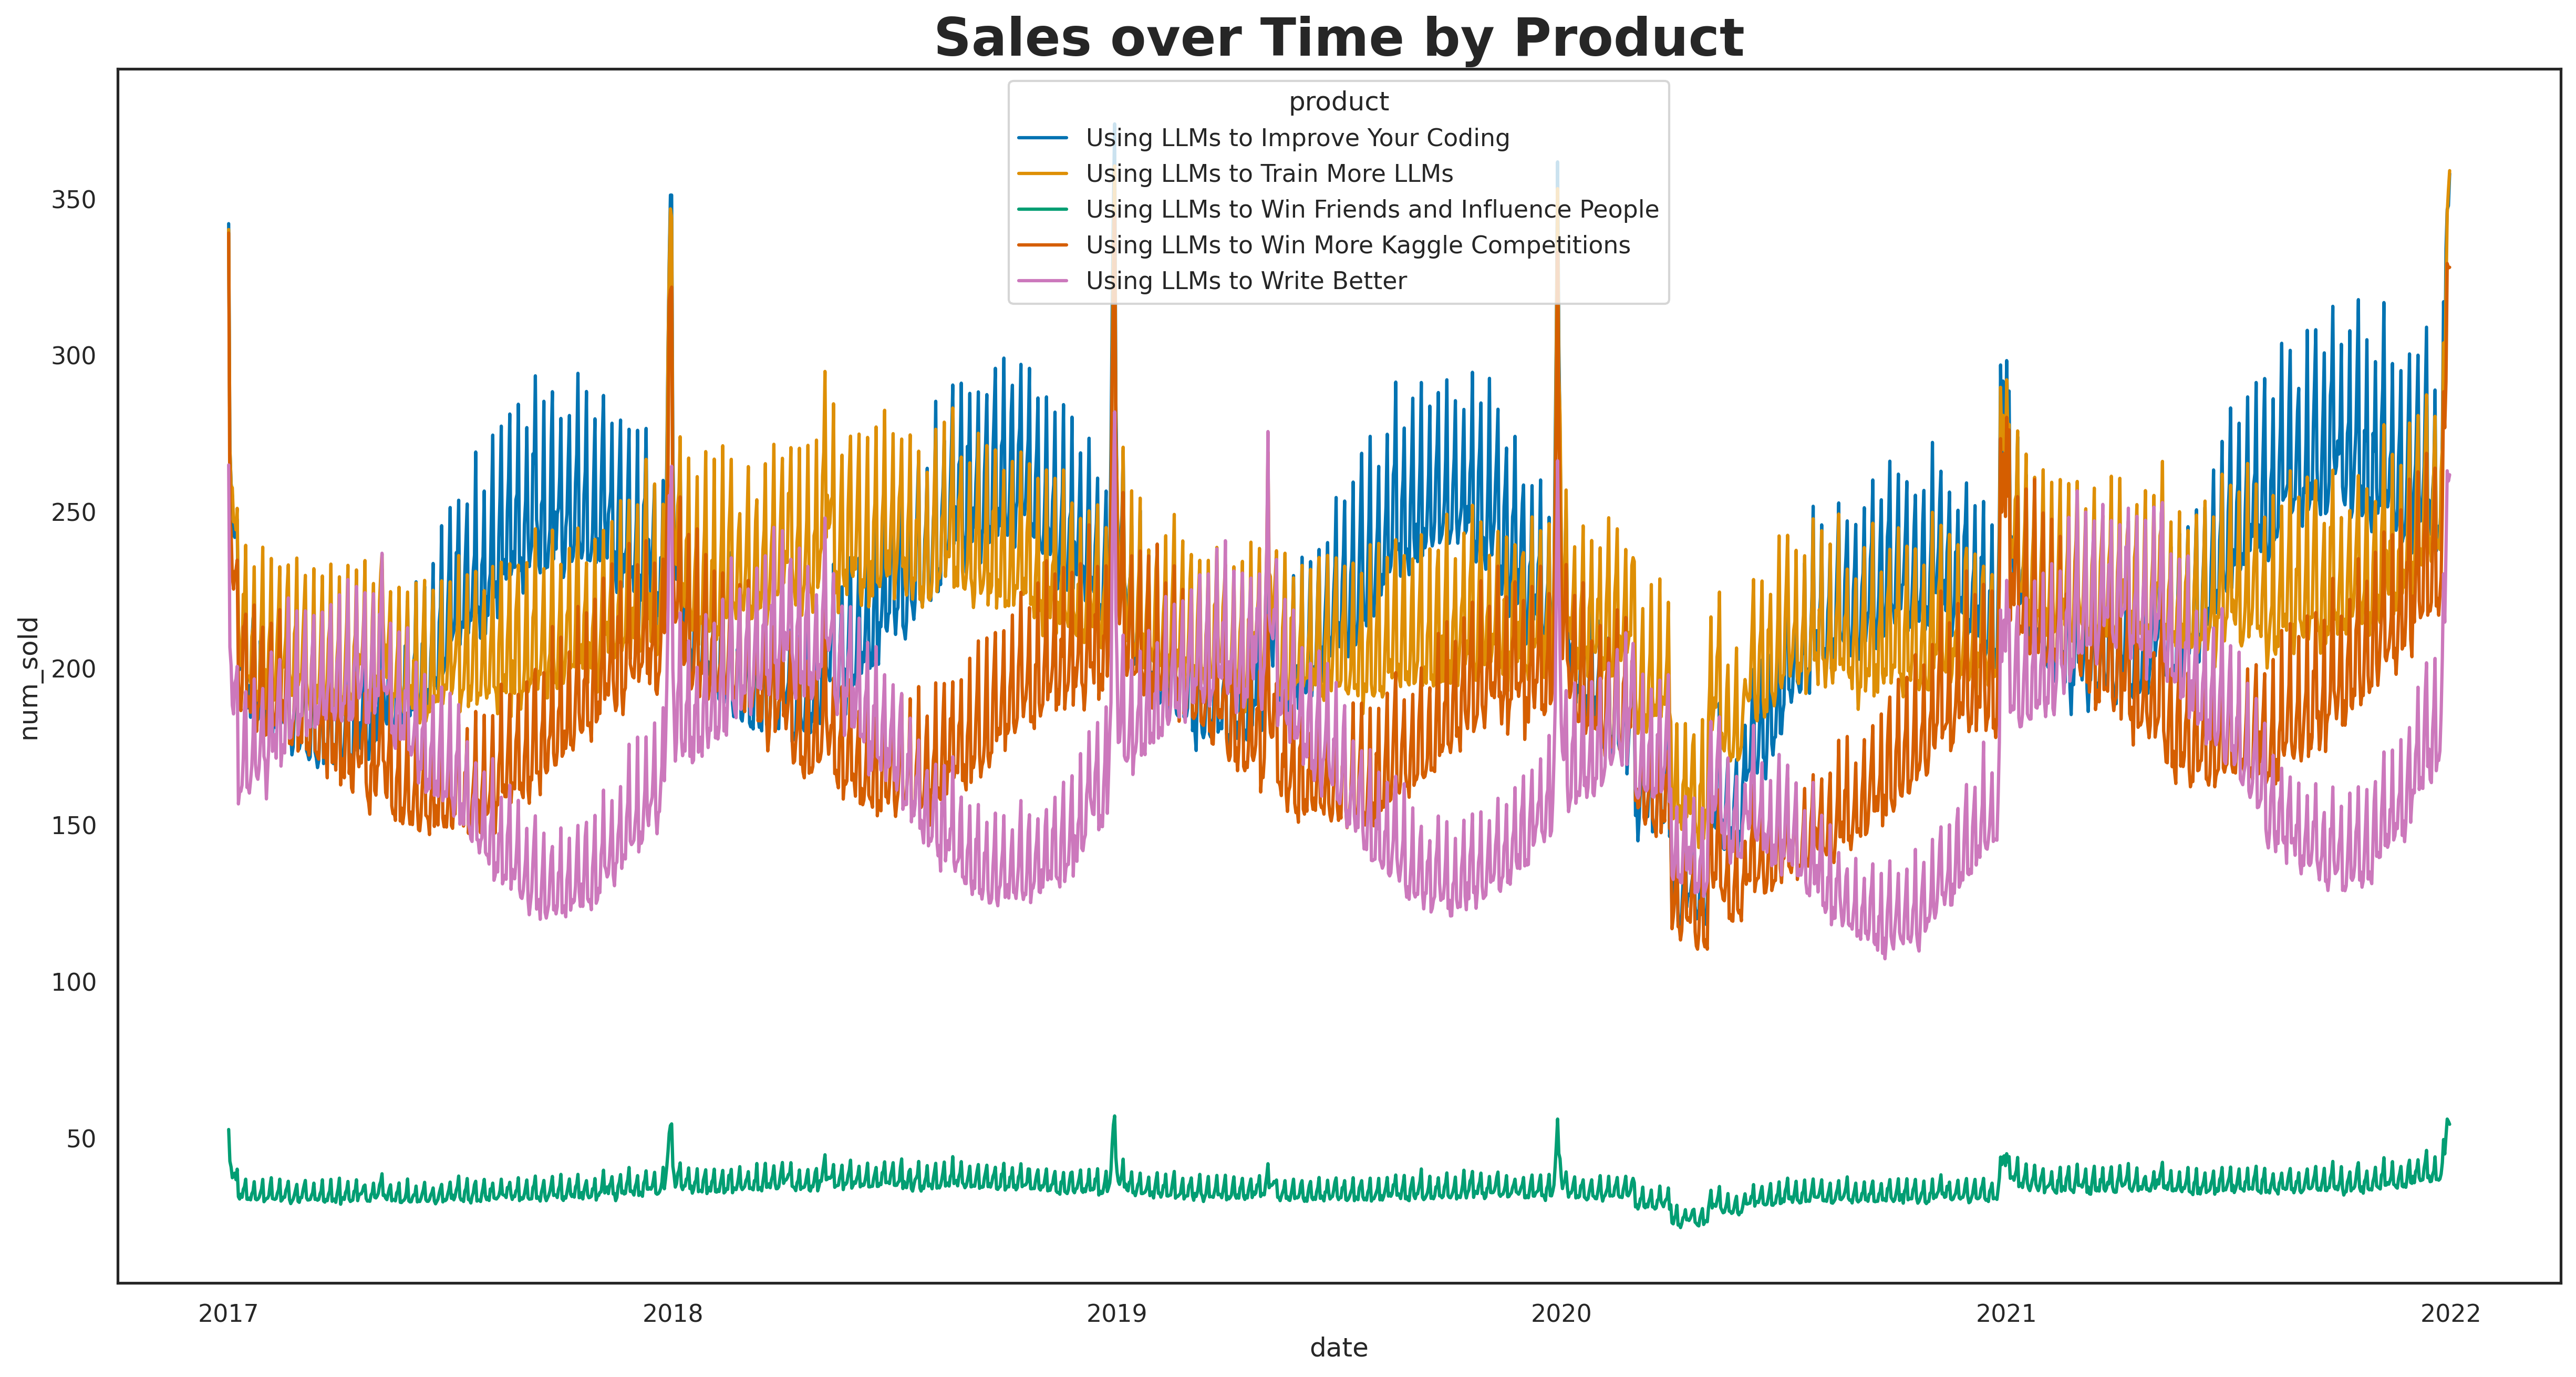

In [29]:
plt.figure(figsize = (20,10), dpi = 300)
sns.lineplot(data = train, x='date', y= 'num_sold', hue = 'product', errorbar = None)

plt.title("Sales over Time by Product", fontsize = 24, fontweight = 'bold')
plt.show()

### Distribution of Categorical Features

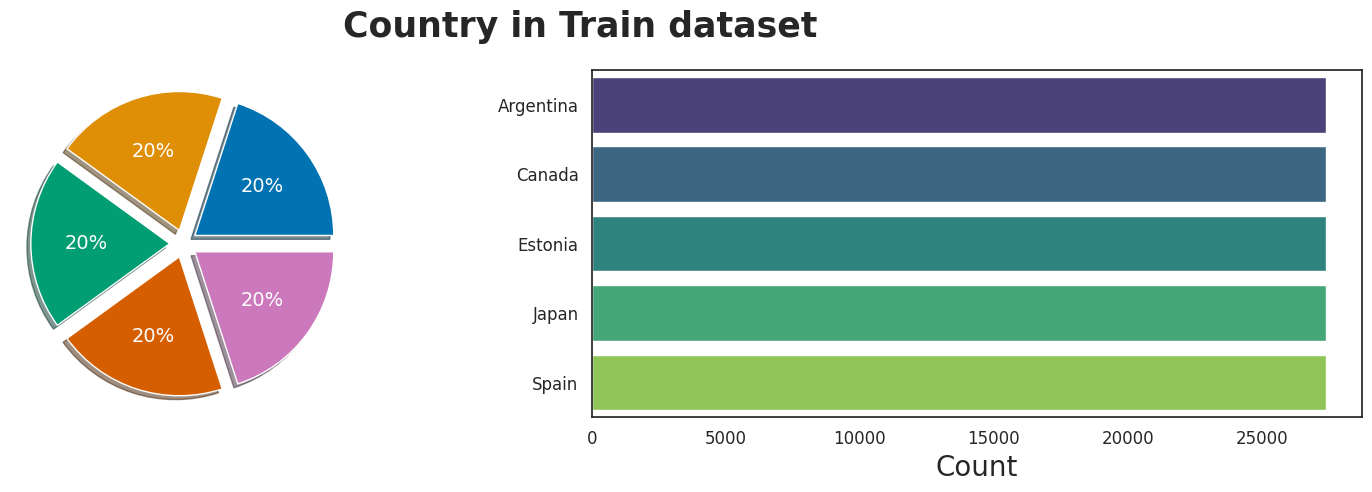

In [30]:
fig, ax = plt.subplots(1,2, figsize = (16,5))
ax = ax.flatten()

ax[0].pie(
    train['country'].value_counts(),
    shadow = True,
    explode = [.1 for i in range(0,5)],
    autopct = '%1.f%%',
    textprops = {'size' : 14, 'color' : 'white'},
)

sns.countplot(data = train, y = 'country', ax = ax[1], palette = 'viridis', order = train['country'].value_counts().index)
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize = 12)
ax[1].set_xlabel('Count', fontsize = 20)
ax[1].set_ylabel(None)
plt.xticks(fontsize = 12)

fig.suptitle('Country in Train dataset', fontsize = 25, fontweight = 'bold')
plt.tight_layout()

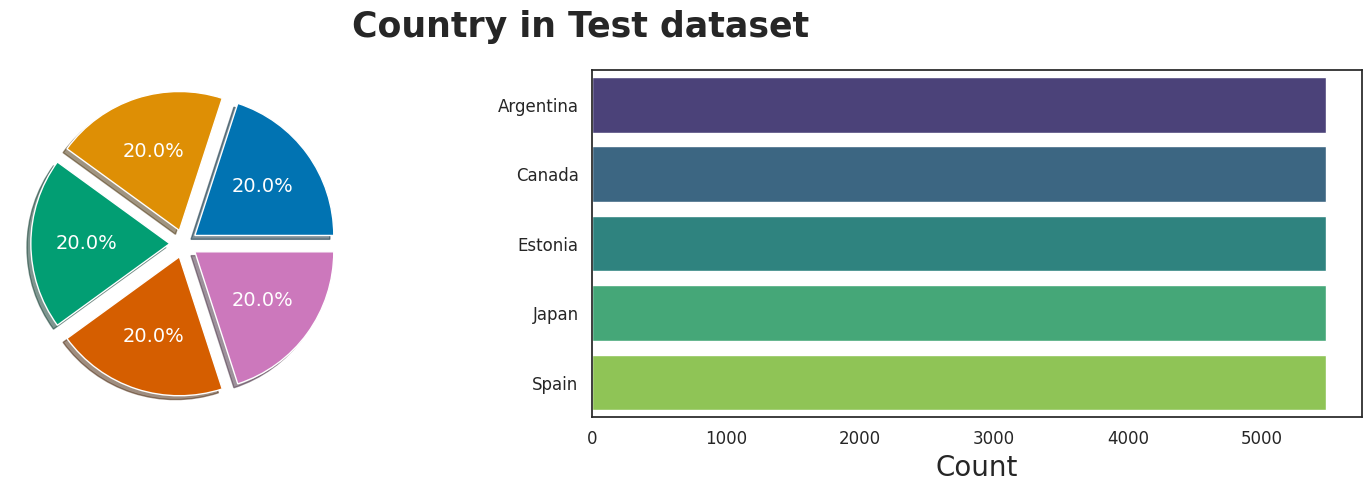

In [34]:
fig, ax = plt.subplots(1,2, figsize = (16,5))
ax = ax.flatten()

ax[0].pie(
    test['country'].value_counts(),
    shadow = True,
    explode = [.1 for i in range(0,5)],
    autopct = '%1.1f%%',
    textprops = {'size' : 14, 'color' : 'white'},
)

sns.countplot(data = test, y = 'country', ax = ax[1], palette = 'viridis', order = train['country'].value_counts().index)
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize = 12)
ax[1].set_xlabel('Count', fontsize = 20)
ax[1].set_ylabel(None)
plt.xticks(fontsize = 12)

fig.suptitle('Country in Test dataset', fontsize = 25, fontweight = 'bold')
plt.tight_layout()

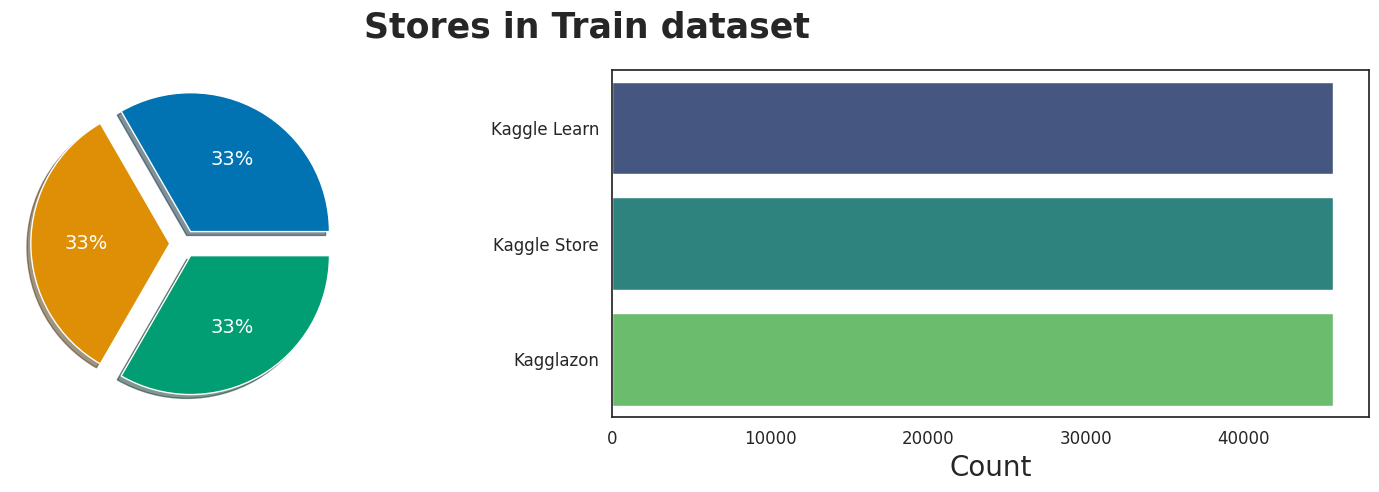

In [38]:
fig, ax = plt.subplots(1,2, figsize = (16,5))
ax = ax.flatten()

ax[0].pie(
    train['store'].value_counts(),
    shadow = True,
    explode = [.1 for i in range(0,3)],
    autopct = '%1.f%%',
    textprops = {'size' : 14, 'color' : 'white'},
)

sns.countplot(data = train, y = 'store', ax = ax[1], palette = 'viridis', order = train['store'].value_counts().index)
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize = 12)
ax[1].set_xlabel('Count', fontsize = 20)
ax[1].set_ylabel(None)
plt.xticks(fontsize = 12)

fig.suptitle('Stores in Train dataset', fontsize = 25, fontweight = 'bold')
plt.tight_layout()

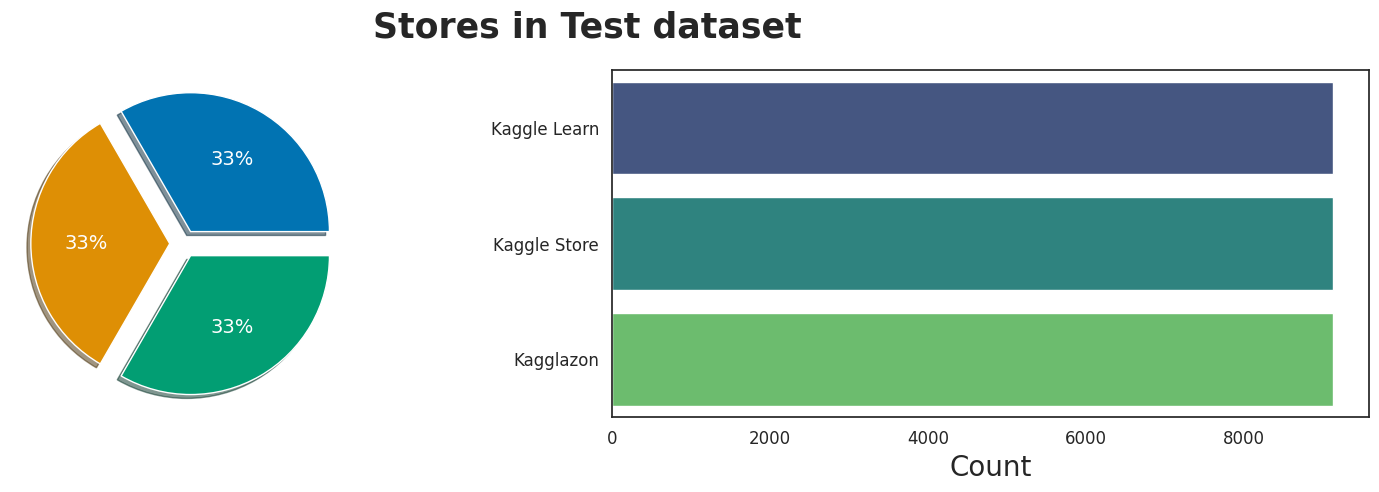

In [39]:
fig, ax = plt.subplots(1,2, figsize = (16,5))
ax = ax.flatten()

ax[0].pie(
    test['store'].value_counts(),
    shadow = True,
    explode = [.1 for i in range(0,3)],
    autopct = '%1.f%%',
    textprops = {'size' : 14, 'color' : 'white'},
)

sns.countplot(data = test, y = 'store', ax = ax[1], palette = 'viridis', order = test['store'].value_counts().index)
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize = 12)
ax[1].set_xlabel('Count', fontsize = 20)
ax[1].set_ylabel(None)
plt.xticks(fontsize = 12)

fig.suptitle('Stores in Test dataset', fontsize = 25, fontweight = 'bold')
plt.tight_layout()

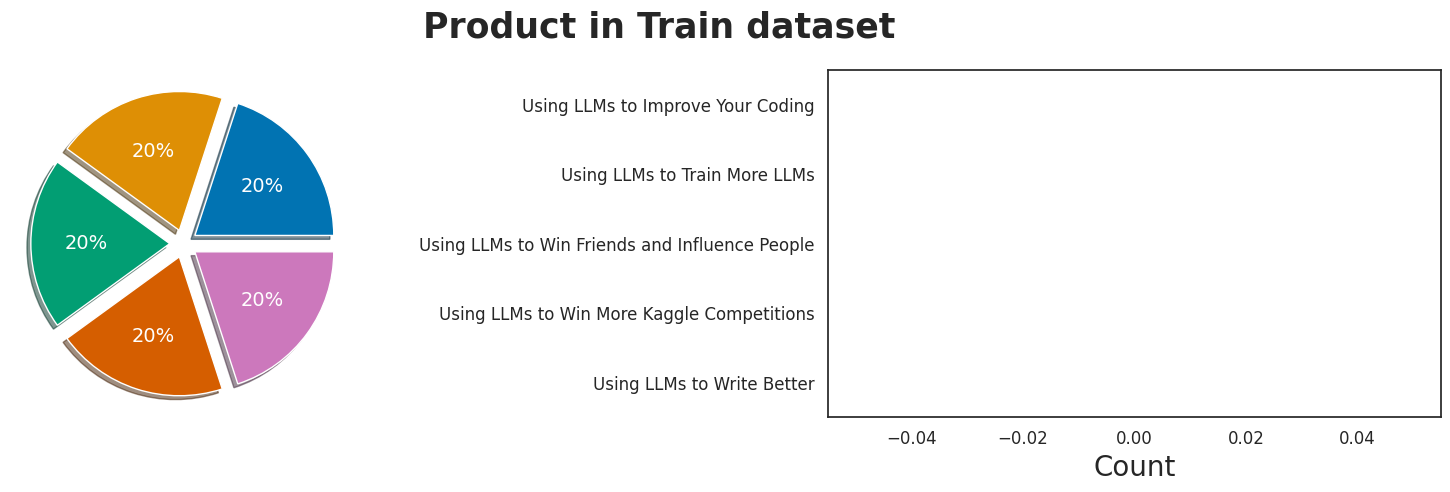

In [44]:
fig, ax = plt.subplots(1,2, figsize = (16,5))
ax = ax.flatten()

ax[0].pie(
    train['product'].value_counts(),
    shadow = True,
    explode = [.1 for i in range(0,5)],
    autopct = '%1.f%%',
    textprops = {'size' : 14, 'color' : 'white'},
)

sns.countplot(data = train, y = 'store', ax = ax[1], palette = 'viridis', order = train['product'].value_counts().index)
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize = 12)
ax[1].set_xlabel('Count', fontsize = 20)
ax[1].set_ylabel(None)
plt.xticks(fontsize = 12)

fig.suptitle('Product in Train dataset', fontsize = 25, fontweight = 'bold')
plt.tight_layout()

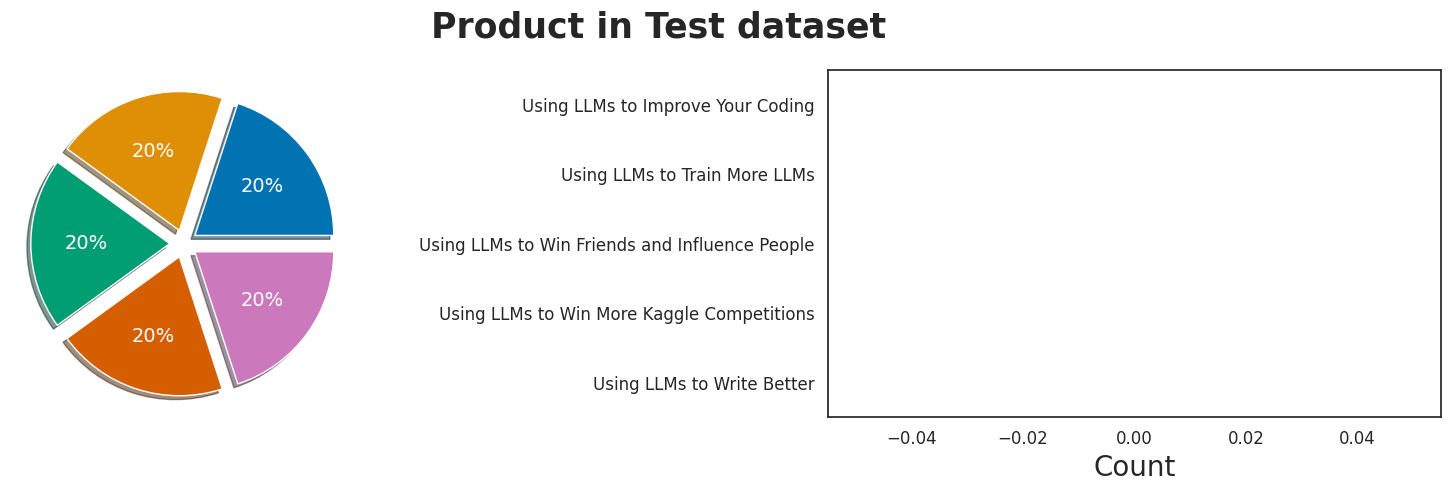

In [45]:
fig, ax = plt.subplots(1,2, figsize = (16,5))
ax = ax.flatten()

ax[0].pie(
    test['product'].value_counts(),
    shadow = True,
    explode = [.1 for i in range(0,5)],
    autopct = '%1.f%%',
    textprops = {'size' : 14, 'color' : 'white'},
)

sns.countplot(data = test, y = 'store', ax = ax[1], palette = 'viridis', order = test['product'].value_counts().index)
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize = 12)
ax[1].set_xlabel('Count', fontsize = 20)
ax[1].set_ylabel(None)
plt.xticks(fontsize = 12)

fig.suptitle('Product in Test dataset', fontsize = 25, fontweight = 'bold')
plt.tight_layout()

### Metrics 

using Symmetrical Mean Absolute Percentage Error (SMAPE) for evaluating results

In [46]:
def smape(A,F):
    return 100/len(A) * np.sum( 2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

### Preparation 

In [47]:
X = train.copy()
y = X.pop('num_sold')
y = np.log1p(y)

seed = 42
k = TimeSeriesSplit(n_splits = 4, test_size = 27390)

np.random.seed(seed)

### Date Processor

Extract features from date. for automating the model pipeline

In [62]:
class DateProcessor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, x, y = None):
        return self
    
    def transform(self, x, y = None):
        
        x_copy = x.copy()
        x_copy['day'] = x_copy.date.dt.day
        x_copy['month'] = x_copy.date.dt.month
        x_copy['year'] = x_copy.date.dt.year
        x_copy['dow'] = x_copy.date.dt.dayofweek
        x_copy = x_copy.drop('date', axis = 1)
        return x_copy

### Post-processor

Imbalance in the data so balancing sales between countries 

In [49]:
def multipliers(predictors, prediction, canada = 1, japan = 1, spain = 1, estonia = 1, argentina = 1):
    prediction[predictors.country == 'Canada'] *= canada
    prediction[predictors.country == 'Japan'] *= japan
    prediction[predictors.country == 'Spain'] *= spain
    prediction[predictors.country == 'Estonia'] *= estonia
    prediction[predictors.country == 'Argentina'] *= argentina
    return prediction

### Cross-Validation Function

detect over-fitting 

In [60]:
def cross_val_score(model, cv = k, label = ''):
    
    X = train.copy()
    y = X.pop('num_sold')
    y = np.log1p(y)
    
    # Init prediction arrays and score lists 
    val_predictions = np.zeros((len(train)))
    train_scores, val_scores = [], []
    
    # Train model, predicting prognosis probability and evaluating log loss
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X,y)):
        
        # define train set 
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        
        # define validation set 
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]
        
        # train model 
        model.fit(X_train, y_train)
        
        # make predictions
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)
        
        val_predictions[val_idx] += val_preds
        
        # reverse log-transformation 
        y_train = np.expm1(y_train)
        y_val = np.expm1(y_val)
        
        train_preds = np.expm1(train_preds)
        val_preds = np.expm1(val_preds)
        
        # evaluate model for a fold 
        
        train_score = smape(y_train, train_preds)
        val_score = smape(y_val, val_preds)
        
        # append model score for a fold to list 
        
        train_scores.append(train_score)
        val_scores.append(val_score)
        
        print(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} \
        | Train Score: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f} | {label}')
        
        return val_scores, val_predictions
        

### Model 

In [56]:
score_list, oof_list = pd.DataFrame(), pd.DataFrame()

models = [
    ('lgb', LGBMRegressor(random_state = seed, objective = 'mae')),
    ('cb', CatBoostRegressor(random_state = seed, verbose = 0, objective = 'MAE')),
    ('gb', GradientBoostingRegressor(random_state = seed, loss = 'absolute_error')),
    ('hgb', HistGradientBoostingRegressor(random_state = seed, loss = 'absolute_error'))
]

Encoder = GLMMEncoder(cols = ['country', 'store', 'product'], random_state = seed)

In [63]:
for (label, model) in models:
    
    score_list[label], oof_list[label] = cross_val_score(
        make_pipeline(DateProcessor(), Encoder, model),
        label = label
    )

Val Score: 12.78067 ± 0.00000         | Train Score: 4.99858 ± 0.00000 | lgb
Val Score: 13.22358 ± 0.00000         | Train Score: 4.34762 ± 0.00000 | cb
Val Score: 14.10913 ± 0.00000         | Train Score: 7.61924 ± 0.00000 | gb
Val Score: 12.83290 ± 0.00000         | Train Score: 5.05277 ± 0.00000 | hgb


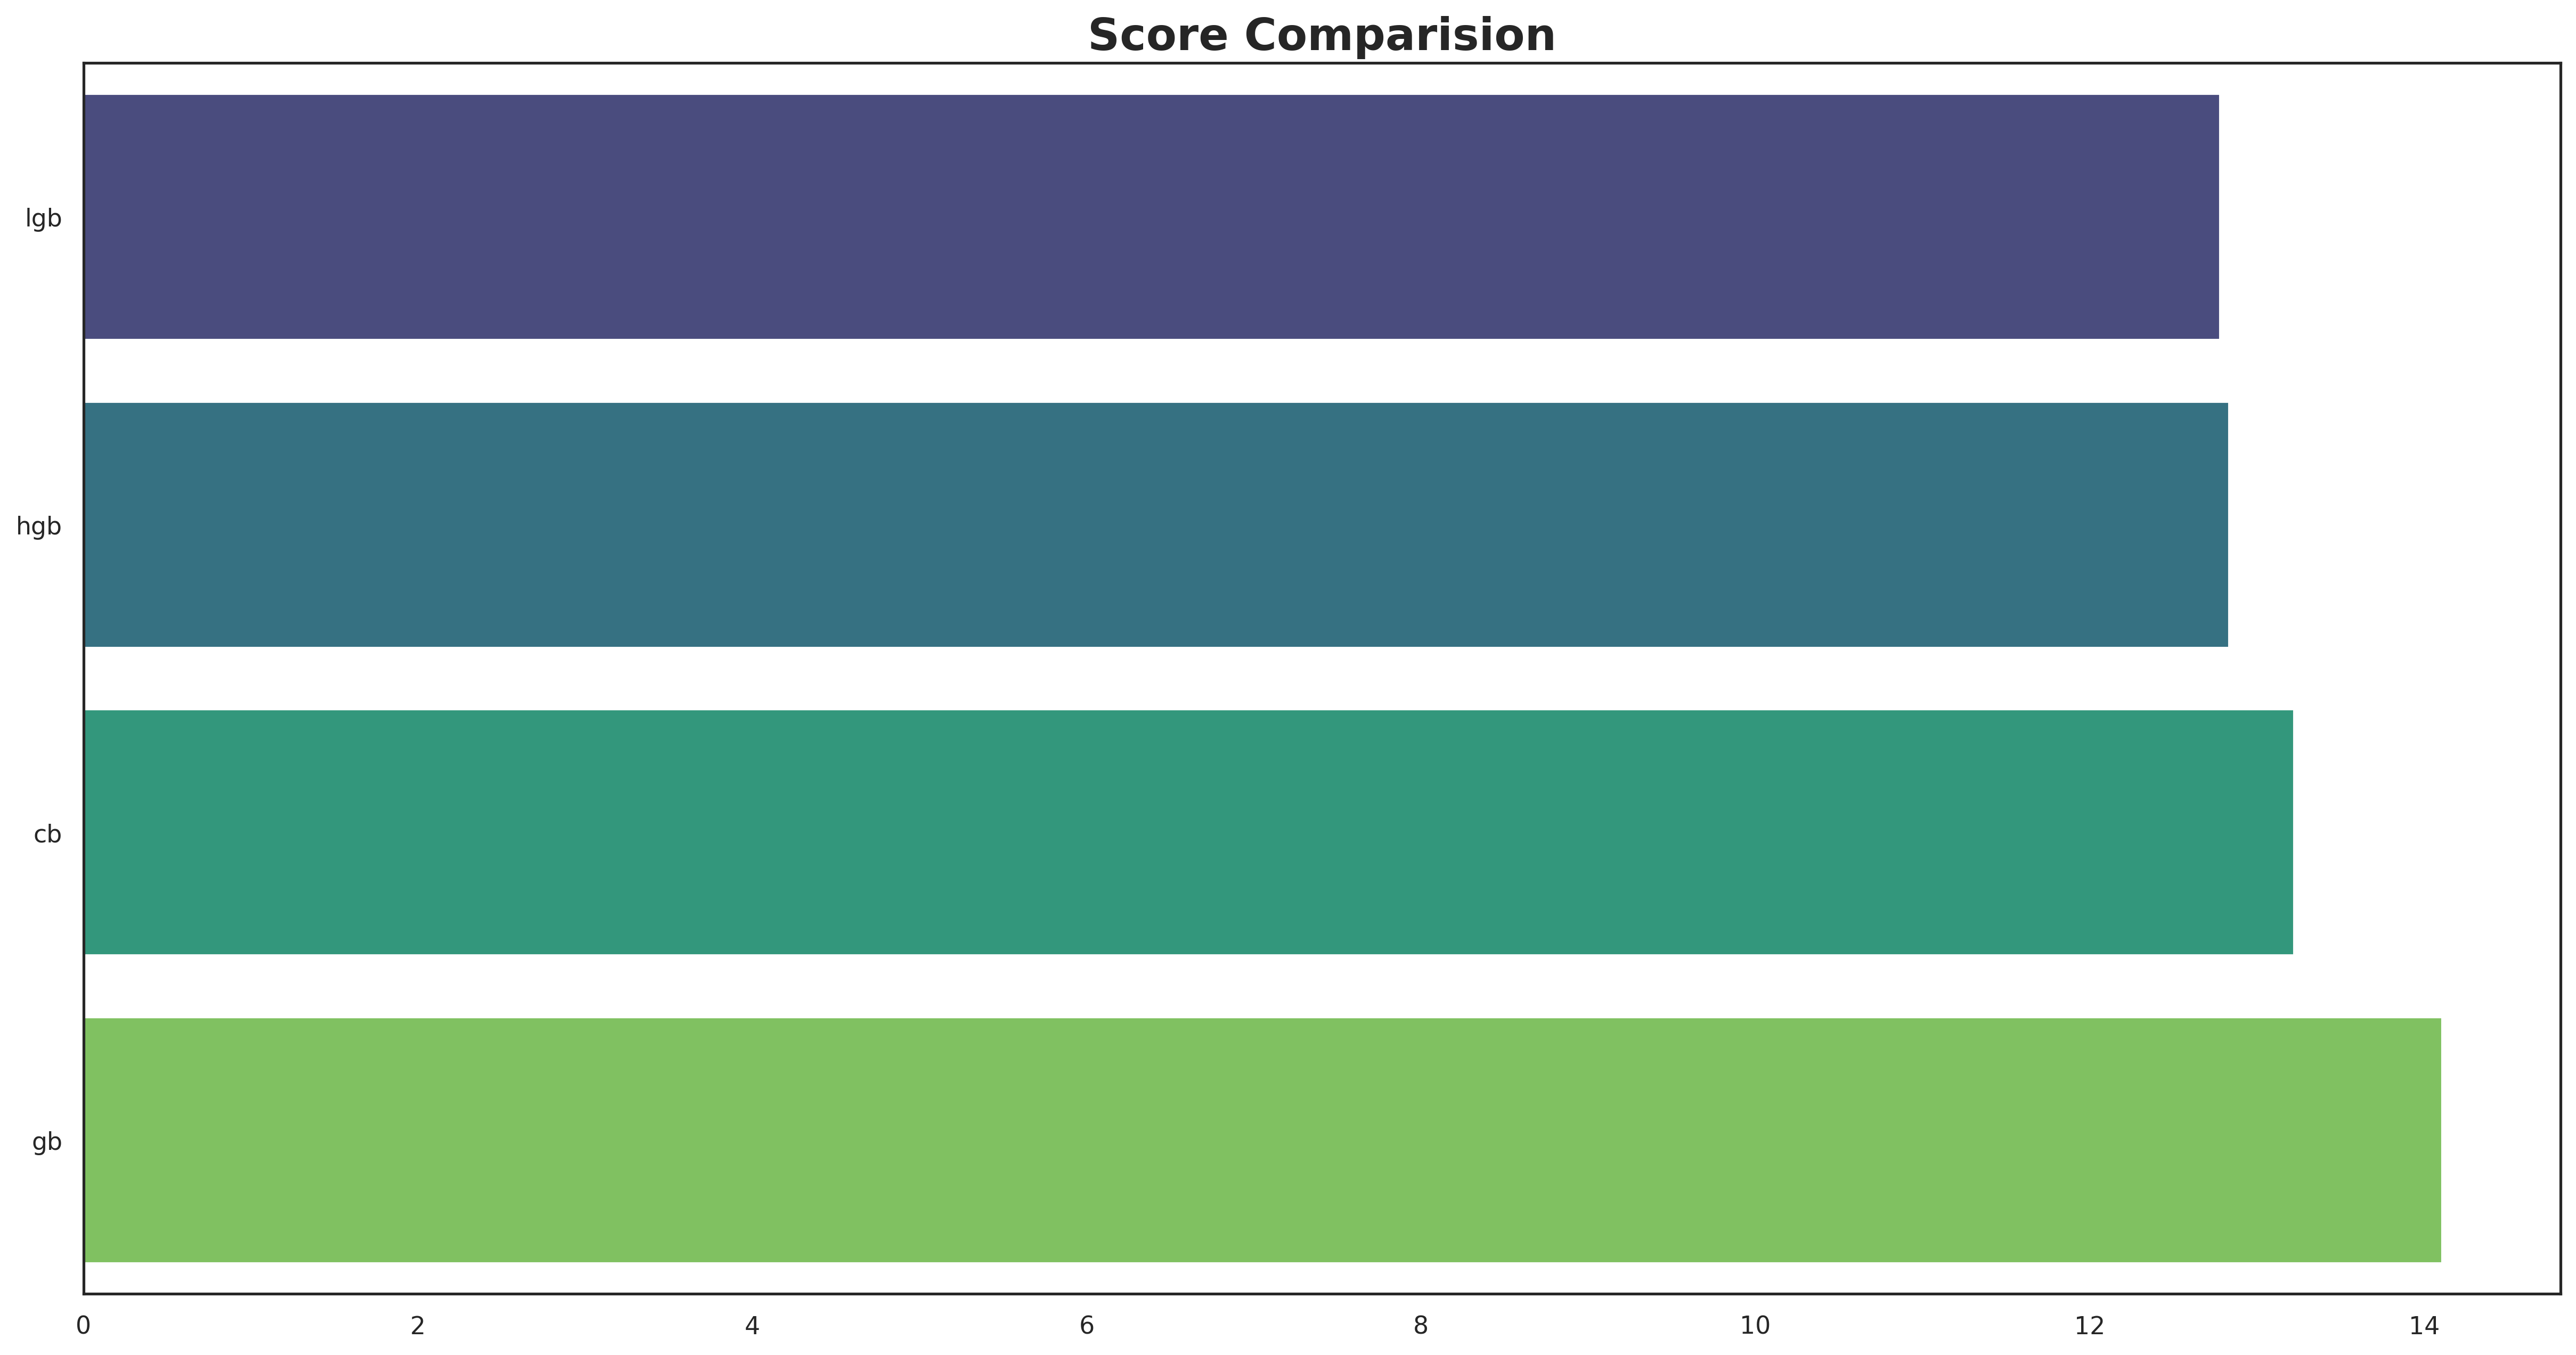

In [65]:
plt.figure(figsize = (20,10), dpi = 300)

sns.barplot(data = score_list.reindex((score_list).mean().sort_values().index, axis = 1), palette = 'viridis', orient = 'h')
plt.title("Score Comparision", weight = 'bold', size = 20)
plt.show()

### Retraining 

Retrain on the entire data set 

In [67]:
model = make_pipeline(DateProcessor(), Encoder, HistGradientBoostingRegressor(random_state = seed, loss = 'absolute_error') )

model.fit(X,y)
prediction = model.predict(test)

### Submission 

In [71]:
test_1 = pd.read_csv("/kaggle/input/playground-series-s3e19/test.csv")
test_1.drop(list(test_1.drop('id', axis = 1)), axis = 1, inplace = True )

test_1['num_sold'] = multipliers(test, np.expm1(prediction) * 1.5, .58, .76, 1, 1.08, 2.82 )
test_1.to_csv('submission.csv', index = False)

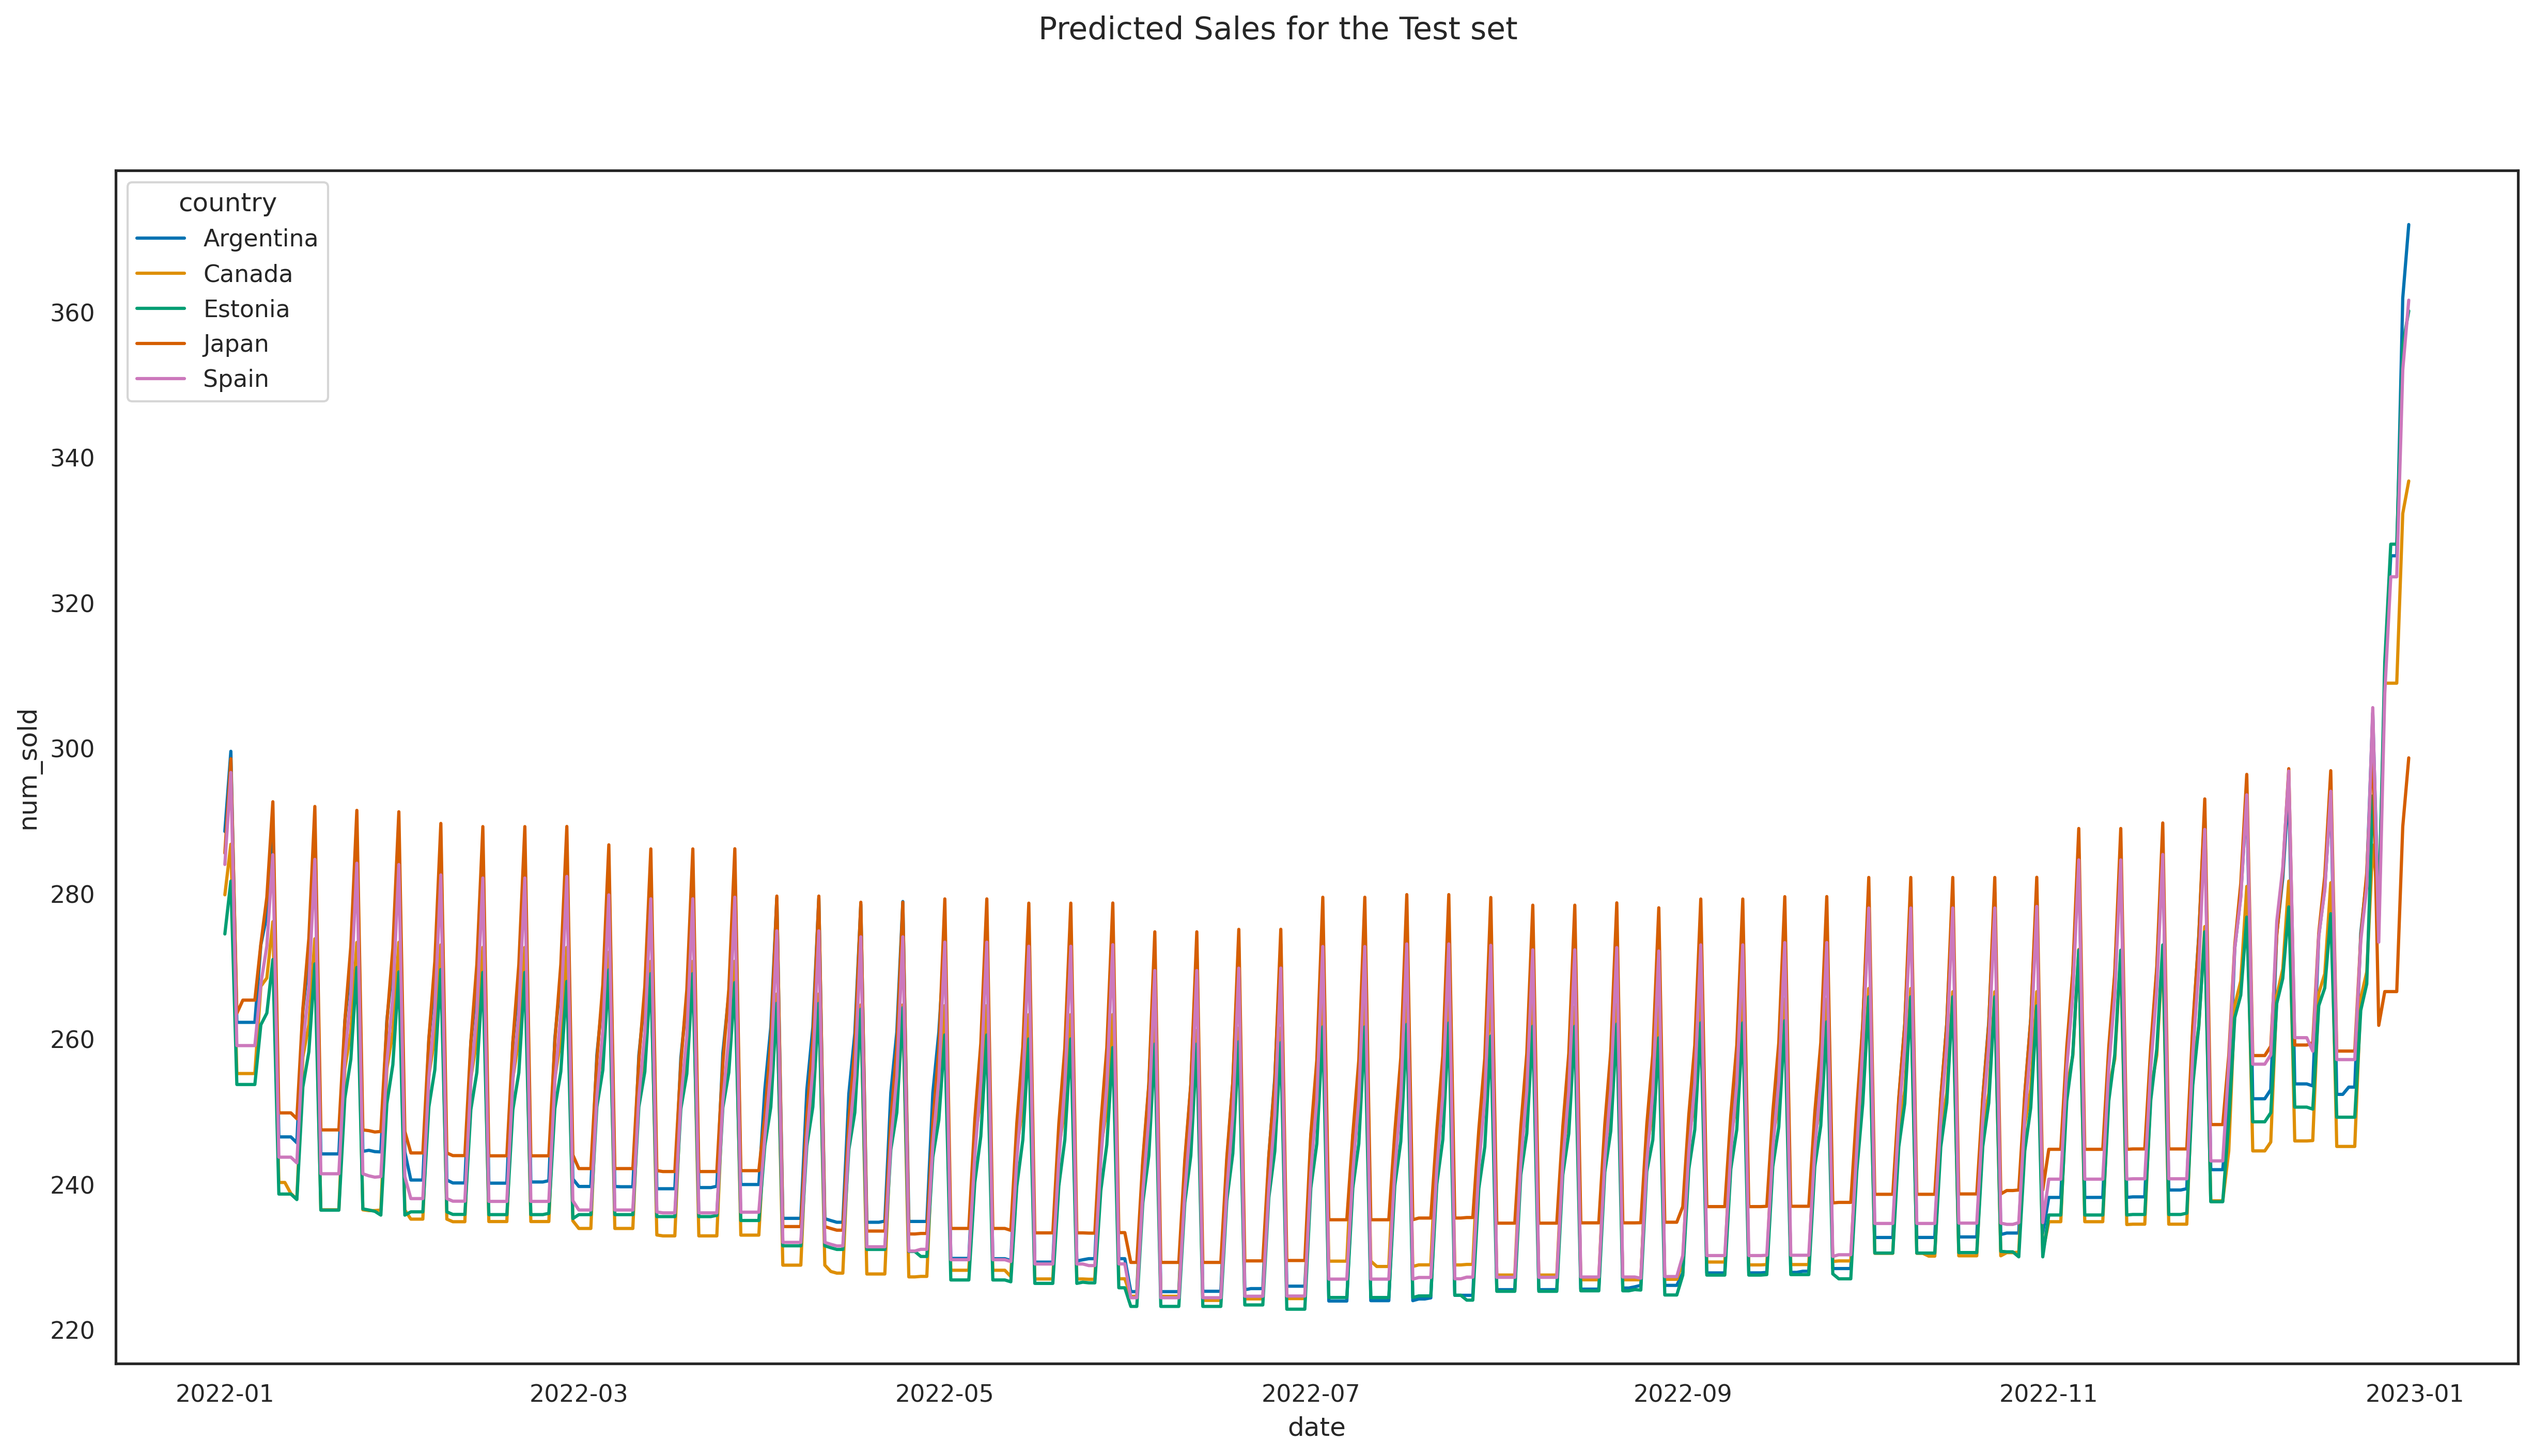

In [73]:
plt.figure(figsize = (20,10), dpi = 300)

sns.lineplot(x = test.date, y = test_1.num_sold, hue = test.country, errorbar = None)

plt.suptitle("Predicted Sales for the Test set")
plt.show()